# Importing the necessary modules

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load our csv file from local device

In [2]:
all_filenames = [i for i in os.listdir("CSV files") if  ".csv" in i and "combined" not in i]
print(all_filenames)

['Agriculture.csv', 'Automobiles.csv', 'Bank.csv', 'Business.csv', 'Economy.csv', 'Education.csv', 'Entertainment.csv', 'Health.csv', 'Health1.csv', 'Health2.csv', 'Politics.csv', 'Politics1.csv', 'Sports.csv', 'Technology.csv', 'Tourism.csv', 'Tourism1.csv', 'World.csv']


# Getting the root of our csv data

In [3]:
root = "CSV files\\"

# Combining the multiple csv file into one file as combined_csv

In [4]:
combined_csv = pd.concat([pd.read_csv(root+f) for f in all_filenames])
combined_csv

,text,category
0,﻿काठमाडौंमा पहिलो पटक स्ट्रबेरीको व्यवसायिक खे...,Agriculture
1,"जिल्लाका किसानले लगाएको अदुवामा गानो कुहिने, ग...",Agriculture
2,काभ्रेपलाञ्चोकमा कृषकले एसआरआई प्रविधिमा गरेको...,Agriculture
3,राजधानीमा यतिबेला तरकारीको मूल्य आकासिएको छ। क...,Agriculture
4,पाल पोल्ट्री तथा लाइभस्टक क्षेत्रको समग्र विका...,Agriculture
...,...,...
117,\r\n﻿बिहार । मुकेश पाठक सहित आधा दर्जन कुख्यात...,world
118,"\r\n﻿राजविराज, २६ साउन । सप्तरी जिल्लामा पहिलो...",world
119,"\r\n﻿वीरगञ्ज, ५ असोज । वीरगञ्जमा भव्यताका साथ ...",world
120,"\r\n﻿वीरगञ्ज, ५ असोज । आत्मा ज्ञान प्रचार संघ ...",world


## Here we are copying the orignal dataframe into df. In case if we change some file the copy dataframe will be change and original data will not be altered 

In [5]:
df = combined_csv.copy()

## We count the news per category

In [6]:
df[["text","category"]].groupby("category").count()

,text
category,
Agriculture,100
automobiles,95
bank,417
business,89
economy,100
education,85
entertainment,72
health,94
politic,165


## Bar plot of above frequency of text file per category

<Axes: xlabel='category'>

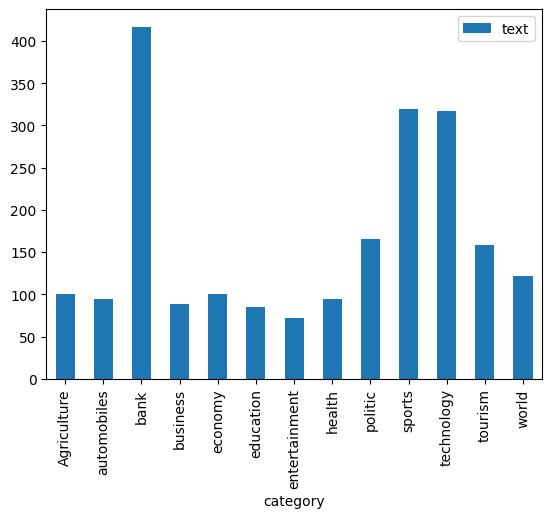

In [7]:
df[["text","category"]].groupby("category").count().plot(kind="bar")

# Load our Stopwords file

In [8]:
stop_file = "nepali_stopwords.txt"
stop_words = []
with open(stop_file, encoding='utf-8') as fp:
    lines = fp.readlines()
    stop_words =list( map(lambda x:x.strip(), lines))
# stop_words

# Load our Punctuation word file

In [9]:
punctuation_file = "nepali_punctuation.txt"
punctuation_words = []
with open(punctuation_file, encoding='utf-8') as fp:
    lines = fp.readlines()
    punctuation_words =list( map(lambda x:x.strip(), lines))
punctuation_words

[':', '?', '|', '!', '.', ',', '" "', "''", '( )', '—', '-', "?'", '\\n']

# Text pre-processing
### Here er wrote a method called preprocess_text that takes data, stop words, and punctuation words as parameters. Then, we created a list called new_cat to hold it. Also initialized noise as numbers. For each words:
   *  #### If word is not in punctuation or stop words then,
   *  #### Do not take this word if it contains noise characters.
   *  #### Remove parenthesis

In [10]:
from snowballstemmer import NepaliStemmer

def preprocess_text(cat_data, stop_words, punctuation_words):
    stemmer = NepaliStemmer() # initialize the Nepali stemmer
  
    new_cat = []
    noise = "1,2,3,4,5,6,7,8,9,0,०,१,२,३,४,५,६,७,८,९".split(",")
  
    for row in cat_data:
        words = row.strip().split(" ")      
        nwords = ""
    
        for word in words:
            # apply Nepali stemming to the word
            if word not in punctuation_words and word not in stop_words:
                word = stemmer.stemWord(word)
                
                is_noise = False
                for n in noise:
                    if n in word:
                        is_noise = True
                        break
                if not is_noise and len(word) > 1:
                    word = word.replace("(","")
                    word = word.replace(")","")
                    nwords += word + " "
                
          
        new_cat.append(nwords.strip())
  
    return new_cat

title_clean = preprocess_text(["\nसगरमाथा चुचुरोमा पुग्ने ९ शेर्पा टोलीको नेतृत्व लेख्नु चाहनुहुन्छ गरेको छ ।"], stop_words, punctuation_words)
print(title_clean)

['सगरमाथा चुचुरो पुग् शेर्पा टोली नेतृत्व लेख्']


In [11]:
ndf = df.copy()
cat_title = []
for i, row in ndf.iterrows():
  ndf.loc[i, "Title"]= preprocess_text([row.text], stop_words, punctuation_words)[0]

# ndf
#if you want to display the title of the news

# Importing the necessary module for Multinomial Naive Bayes

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Splitting data into Train and Test set
  ### Here we are splitting the Train data as 80% and Test data as 20%. Train data are used for model fitting and test data are used while doing model prediction. But before that, we     will merge two similar categories into one and also assign a unique label for each class.

In [13]:
data = pd.DataFrame()

data["text"]=ndf.text
# Preprocess the text data
data["text"] = preprocess_text(data["text"], stop_words, punctuation_words)


# data["category"]=ndf.category

data["label"]=ndf.category
data["target"] = data["label"].apply(lambda x: "news" if x=="prabhas-news" else "national" if x=="province" else x)
classes = {c:i for i,c in enumerate(data.target.unique())}
data["target"] = data.target.apply(lambda x: classes[x])


X_train, X_test, Y_train, Y_test = train_test_split(data["text"],data["target"],test_size=0.2, random_state=1)

vectorizer = CountVectorizer(ngram_range=(1, 2)).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)
print(X_train_vectorized)
X_train_vectorized.shape

  (0, 6436)	1
  (0, 6498)	1
  (0, 6919)	1
  (0, 6930)	1
  (0, 16716)	1
  (0, 16842)	1
  (0, 20705)	1
  (0, 20831)	1
  (0, 25056)	1
  (0, 25084)	1
  (0, 27302)	1
  (0, 27324)	1
  (0, 29295)	1
  (0, 29348)	1
  (0, 34548)	1
  (0, 34589)	1
  (0, 40244)	1
  (0, 40251)	1
  (0, 43148)	1
  (0, 43149)	1
  (0, 52415)	1
  (0, 52565)	1
  (0, 57032)	1
  (0, 61556)	1
  (0, 61838)	1
  :	:
  (1706, 87878)	1
  (1706, 88126)	1
  (1706, 88147)	4
  (1706, 88226)	1
  (1706, 88330)	1
  (1706, 88342)	2
  (1706, 88642)	2
  (1706, 88646)	1
  (1706, 88837)	1
  (1706, 89052)	2
  (1706, 89055)	1
  (1706, 89065)	1
  (1706, 89128)	1
  (1706, 89217)	1
  (1706, 89282)	1
  (1706, 89289)	1
  (1706, 89617)	3
  (1706, 89731)	1
  (1706, 89733)	2
  (1706, 89965)	1
  (1706, 90017)	1
  (1706, 90281)	1
  (1706, 90385)	1
  (1706, 90841)	1
  (1706, 91120)	1


(1707, 92201)

In [14]:
tfidf_transformer=TfidfTransformer()
X_train_tfidf=tfidf_transformer.fit_transform(X_train_vectorized)
X_train_tfidf.shape

(1707, 92201)

# Model Fitting 
### We fit MultinomialNB by using Train set of data. We get value of coefficent of determination 99.86% that means the model is able to fit only 99.86% of data.

In [15]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer

class Multinomial:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.vectorizer = None
        
    
    def fit(self, X, y):
        # Convert text to word count matrix
        X_sparse = X
        
        # Get unique class labels and their counts
        self.classes, class_counts = np.unique(y, return_counts=True)
        n_classes = len(self.classes)
        
        # Calculate class prior probabilities
        self.class_prior = class_counts / np.sum(class_counts)
        
        # Calculate count of each feature per class and add smoothing
        feature_count = np.zeros((n_classes, X_sparse.shape[1]))
        for i in range(n_classes):
            Xi = X_sparse[y == self.classes[i]]
            feature_count[i, :] = np.array(Xi.sum(axis=0)).flatten() + self.alpha
        
        # Calculate count of each class
        class_count = feature_count.sum(axis=1)
        
        # Calculate log probability of each feature for each class
        self.feature_log_prob = (np.log(feature_count) - np.log(class_count.reshape(-1, 1)))
        
        return self
    
    def _log_prob(self, X):
        # Calculate log probability of each class for each sample
        return X @ self.feature_log_prob.T + np.log(self.class_prior)
    
    def predict(self, X):
        X_sparse = X
        
        # Calculate log probability of each class for each sample
        log_prob = self._log_prob(X_sparse)
        
        # Find class with highest log probability for each sample
        y_pred = np.argmax(log_prob, axis=1)
        
        # Map class index to label
        return self.classes[y_pred]
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)  

In [16]:
model = Multinomial(alpha=0.1)
model.fit(X_train_vectorized, Y_train)
model.score(X_train_vectorized, Y_train)

0.9976567076742824

# Accuracy

In [17]:
predictions = model.predict(vectorizer.transform(X_test))
print("Accuracy:", 100 * sum(predictions == Y_test) / len(predictions), '%')

Accuracy: 82.20140515222482 %


In [18]:
x_train_transformed = vectorizer.transform(X_test)

In [19]:
y_predicted = model.predict(x_train_transformed)

# Calculating the precison, recall and f1 score of out Test data set

In [20]:
PRECISION_SCORE = precision_score(Y_test, y_predicted, average='weighted')
RECALL_SCORE = recall_score(Y_test, y_predicted, average='weighted')
F1_SCORE = f1_score(Y_test, y_predicted, average='weighted')
print("PRECISION_SCORE :" ,PRECISION_SCORE)
print("RECALL_SCORE :" ,RECALL_SCORE)
print("F1_SCORE :" ,F1_SCORE)

PRECISION_SCORE : 0.8354540206881994
RECALL_SCORE : 0.8220140515222483
F1_SCORE : 0.8188335629763971


# Confusion Matrix

In [21]:
confusion_matrix(Y_test, y_predicted)

array([[11,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 14,  0,  3,  0,  0,  0,  0,  1,  0,  0,  3,  0],
       [ 0,  2, 73,  1,  1,  0,  0,  0,  0,  0,  1,  0,  2],
       [ 0,  0,  2, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  5,  2,  5,  0,  0,  0,  1,  0,  0,  2,  0],
       [ 0,  0,  2,  2,  1, 12,  0,  0,  2,  0,  0,  0,  1],
       [ 1,  0,  1,  2,  1,  0, 12,  0,  1,  0,  0,  2,  1],
       [ 0,  0,  0,  0,  0,  0,  0, 18,  4,  0,  0,  0,  1],
       [ 0,  0,  1,  1,  0,  0,  0,  0, 36,  0,  0,  0,  0],
       [ 0,  1,  2,  1,  0,  1,  0,  0,  1, 55,  0,  0,  2],
       [ 0,  0,  1,  1,  0,  0,  0,  0,  0,  0, 53,  0,  0],
       [ 1,  0,  0,  0,  2,  1,  0,  0,  0,  0,  0, 28,  0],
       [ 1,  0,  1,  3,  0,  1,  0,  0,  0,  0,  0,  0, 15]], dtype=int64)

# Creating the unique class for different category

In [22]:
model.classes, classes

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64),
 {'Agriculture': 0,
  'automobiles': 1,
  'bank': 2,
  'business': 3,
  'economy': 4,
  'education': 5,
  'entertainment': 6,
  'health': 7,
  'politic': 8,
  'sports': 9,
  'technology': 10,
  'tourism': 11,
  'world': 12})

# Finally we predict our untrained data and try to find the right category

In [23]:
prd = model.predict(vectorizer.transform(
    [
        'काठमाडौँ — पूर्वअर्थमन्त्रीहरूले आगामी बजेटमार्फत अनावश्यक खर्च कटौती र नयाँ आयोजना नथप्न सुझाएका छन् । आर्थिक वर्ष ०८०/८१ को बजेट तयारीसम्बन्धमा अर्थमन्त्री प्रकाशरण महतले शुक्रबार बोलाएको छलफलमा उनीहरूले व्यावहारिक बजेट तयार गर्न र खर्च कटौतीमा निर्मम बन्नुपर्नेमा जोड दिए ।'
    ])
            ) 
nprd = []
for k,v in classes.items():
  for p in prd:
    if v==p:
      nprd.append(k)
nprd

['politic']

In [54]:
import pickle

In [55]:
filename = 'news_pred_model.pickle'
pickle.dump(model,open(filename,'wb'))

In [56]:
filename = 'news_pred_vectorizer.pickle'
pickle.dump(vectorizer,open(filename,'wb'))

In [11]:
# !pip install snowballstemmer

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/93.0 kB ? eta -:--:--
     -------------                            30.7/93.0 kB 1.3 MB/s eta 0:00:01
     -------------------------              61.4/93.0 kB 656.4 kB/s eta 0:00:01
     -------------------------------------- 93.0/93.0 kB 880.4 kB/s eta 0:00:00
